In [2]:
#!pip install matplotlib


Text(0.5, 1.0, 'Filtered CSI stream (Ord 12) - Silence removed')

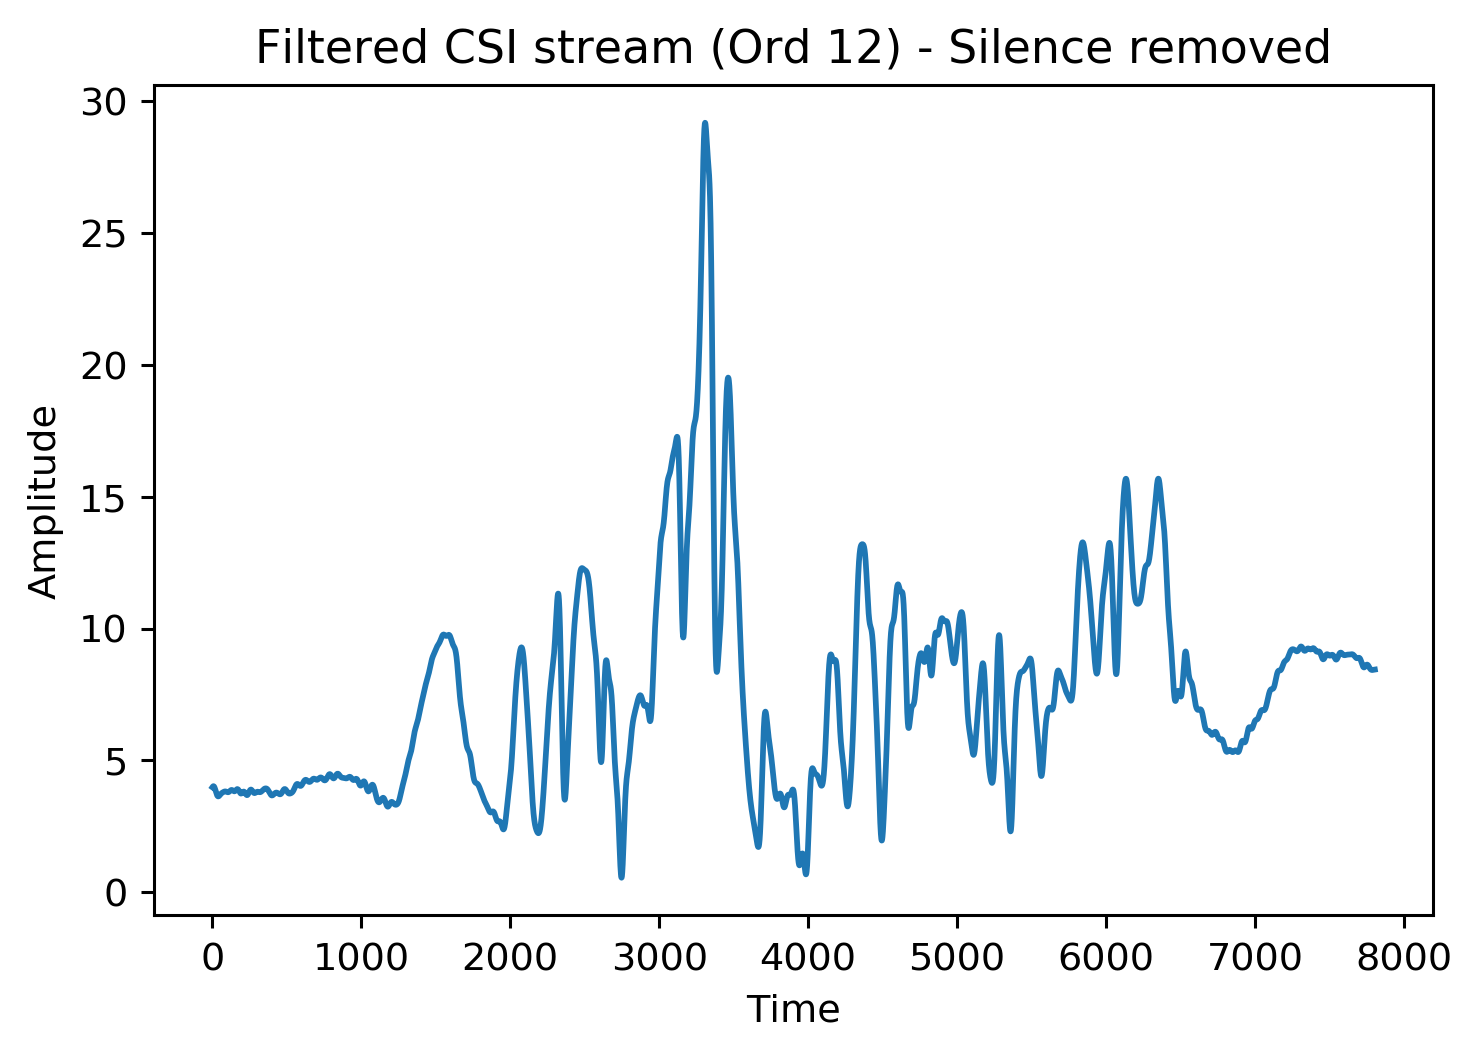

In [8]:

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import numpy as np
from scipy.signal import butter, lfilter, filtfilt, medfilt
from numpy.fft import fft, fftfreq

matlab_file = './Sushant_CSI/1m/backward_converted/log_2.mat'
plt.rcParams['figure.dpi'] = 275

original = [] # Dataset with trimmed csi streams, removed silence
selected_subcarrier = 0

mat_contents = sio.loadmat(matlab_file)
antenna = mat_contents['M']

# -- APPLY BUTTERWORTH FILTER --
for subcarrier in range(90):
    fs = 0.05        # Sampling Frequency
    flt_ord = 12     # Filter order number

    # Create list of CSI stream of one subcarrier
    x_axis = []
    y_axis = []
    for i in range(0, len(antenna)):
        x_axis.append(i)
        y_axis.append(antenna[i][subcarrier])

    flt_ord = 12
    b, a = butter(flt_ord, 0.05, 'lowpass', analog=False)
    output = filtfilt(b, a, y_axis)
    original.append(output)


# -- SILENCE REMOVAL ---
# Separate the CSI data into a sequence of frames
num_packets = len(original[selected_subcarrier])
data_per_frame = 50    # 50 ms is the number of data(frequency) in each frame.
total_num_frames = math.floor(num_packets/data_per_frame) 
frames = []
for frame in range(int(total_num_frames)):
    cur_index = data_per_frame*frame
    seq = original[selected_subcarrier][cur_index : cur_index+data_per_frame]
    frames.append(seq)


# Calculate energy for each frame
# Energy each frame = Average of the Squares for each frame
energy = []
for frame in frames:
    sq_sum = sum(map(lambda x: x*x, frame))
    e_frame = sq_sum/data_per_frame
    energy.append(e_frame)

# Apply median filter to energy values and take their log
filt_energy = medfilt(energy)
filt_energy = [math.log(e) for e in filt_energy]

# Select contiguous block of frames s_mid for which energy > mean energy

# Get indices for which energy > mean energy
curr_index = 0
high_energy_indices = []
mean_energy = sum(filt_energy)/len(filt_energy)
for energy in filt_energy:
    if energy > mean_energy:
        high_energy_indices.append(curr_index)
    curr_index += 1;

# Split the high energy indices into contigious subsequences
curr_index = None
inside_arr = []
conti_arr = []
for index in high_energy_indices:
    if (curr_index is None):
        inside_arr.append(index)
    else:
        if (curr_index == index-1):
            inside_arr.append(index)
        else:
            conti_arr.append(inside_arr)
            inside_arr = []
            inside_arr.append(index)

    curr_index = index

if inside_arr:
    conti_arr.append(inside_arr)

# Select the longest contigious subsequence
s_mid = max(conti_arr, key=len)

# Get the corresponding CSI data frames h_mid for s_mid
h_mid = []
for index in s_mid:
    h_mid.append(frames[index])

    
# Calculate the midpoint of the region h_mid which has maximum
# deviations from the average in h_mid
high_energy_csi = [item for sublist in h_mid for item in sublist]
avg_energy = sum(high_energy_csi)/len(high_energy_csi)

max_dev = 0
max_dev_index = 0
for index, energy in enumerate(high_energy_csi):
    deviation = abs(avg_energy - energy)
    if deviation > max_dev:
        max_dev = deviation
        max_dev_index = index

m = s_mid[0] * data_per_frame + max_dev_index 

# Set start_point to m−T/2, where T is total duration
start_point = math.floor(m - (num_packets)/2)
start_point = max(start_point, 0)

# Set end_point to m+T/2, where T is total duration
end_point = math.floor(m + (num_packets)/2)
end_point = min(end_point, num_packets)

# Get original data with silence removed
trimmed_output = original[selected_subcarrier][start_point:end_point]

# silenced_data = [] # Contains the original csi data for which each subcarrier is trimmed from best_start to best_end
# for untrimmed in original:
#     new_csi = untrimmed[start_point:end_point]
#     silenced_data.append(new_csi)


# # Plot the silenced CSI data
# for silenced in silenced_data:
plt.plot(trimmed_output)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered CSI stream (Ord 12) - Silence removed')

In [ ]:
# SIGNAL SEPARATION
# Now start Signal separation
silenced_csi_signal = silenced_data[selected_subcarrier]
mean_silenced = sum(silenced_csi_signal)/len(silenced_csi_signal)
shifted_data = [i - mean_silenced for i in silenced_csi_signal]

plt.axhline(y=0, color='r', linestyle='-')
plt.plot(shifted_data)

# 

In [ ]:
# Perform FFT
n = len(shifted_data)
timestep = 1
freq = np.fft.fftfreq(n, d=timestep)
mask = freq > 0
xmin = 0.002; xmax = 0.008
ymin = 0; ymax = 1

frequency_data = fft(shifted_data)
fft_theo =2.0*np.abs(frequency_data/n)
plt.axis([xmin,xmax,ymin,ymax])
plt.plot(freq[mask], fft_theo[mask])

# print(freq[mask])
print(fft_theo[mask])

In [ ]:
from scipy.stats import kurtosis, skew
#from skrebate import ReliefF
#from sklearn.pipeline import make_pipeline
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import cross_val_score


# Feature extraction shit here.
num_packets = len(silenced_data[0])
data_per_window = 100
total_num_windows = math.floor(num_packets/data_per_window) 

# Split data into windows of 100 packets / 0.1 seconds
windows = []
for window in range(int(total_num_windows)):
    cur_index = data_per_window*window
    seq = silenced_data[0][cur_index : cur_index+data_per_window]
    
    windows.append(seq)

#print(windows)

features = []

def getZeroCrossingRate(arr):
        my_array = np.array(arr)
        #print(my_array)
        return float("{0:.2f}".format((((my_array[:-1] * my_array[1:]) < 0).sum())/len(arr)))
    
def getMeanCrossingRate(arr):
    #print(arr)
    return getZeroCrossingRate(np.array(arr) - np.mean(arr))

# For each window, gather its features
for each_window in windows:
    # time domain features
    
    weight_each_window = []
    
    mean = sum(each_window) / len(each_window)
    max_val = max(each_window)
    min_val = min(each_window)
    skewness = skew(each_window)
    kurtosis_val = kurtosis(each_window)
    variance = np.var(each_window)
    
    # !!! MEAN crossing rate shit doesnt work !!!
    mean_crossing_rate = getMeanCrossingRate(each_window)
    
    weight_each_window.append(mean)
    weight_each_window.append(max_val)
    weight_each_window.append(min_val)
    weight_each_window.append(skewness)
    weight_each_window.append(kurtosis_val)
    weight_each_window.append(variance)
    weight_each_window.append(mean_crossing_rate)
    
    features.append(weight_each_window)
    
# # print(mean)
# # print(max_val)
# # print(min_val)
# # print(skewness)
# # print(kurtosis_val)
# # print(variance)
# # print(mean_crossing_rate)

# # print(features)
# label_len = len(features)
# labels = np.zeros(label_len)

# print(labels)
# clf = make_pipeline(ReliefF(n_features_to_select=2, n_neighbors=100),
#                     RandomForestClassifier(n_estimators=100))


# print(clf)
# print(np.mean(cross_val_score(clf, features, labels)))



In [ ]:

# Doing the classifying using features above

